In [1]:
import matplotlib.pyplot as plt
import nltk
import pandas as pd

from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [2]:
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /Users/krusand/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/krusand/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krusand/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Variation in Claims
This notebook investigates the variation of the generated claims.

In [3]:
claim_df = pd.read_csv("claims.csv")
claim_df.head()

,Detail level,Claim,Soft/hard,Color,Annotator
0,High,Excited to apply for position,Soft,Orange,aksv
1,High,Studying Data Science at the IT University,Hard,Green,aksv
2,High,Eager to apply analytical and technical skills,Soft,Orange,aksv
3,High,1.5 years as student data analyst in the medic...,Hard,Green,aksv
4,High,Strong skills in Python,Hard,Green,aksv


Number of claims for each detail level:

In [4]:
claim_df["Detail level"].value_counts()

Detail level
High      92
Low       85
Medium    80
Name: count, dtype: int64

Number of claims for each type of claim (soft/hard):

In [5]:
claim_df["Soft/hard"].value_counts()

Soft/hard
Soft    215
Hard    132
Name: count, dtype: int64

Number of claims per combination of detail level and claim type (soft/hard):

In [6]:
claim_df["level_type"] = claim_df["Detail level"] + " " + claim_df["Soft/hard"]
claim_df["level_type"].value_counts()

level_type
Low Soft       64
Medium Soft    51
High Hard      49
High Soft      43
Medium Hard    29
Low Hard       21
Name: count, dtype: int64

Number of claims per annotator:

In [8]:
claim_df["Annotator"].value_counts()

Annotator
idwe    91
swae    87
bhei    86
aksv    83
Name: count, dtype: int64

#### Analyzing the contents of the claims

In [9]:
# function to stem and tokenize text
def stem_and_tokenize(text):
    stemmer = PorterStemmer()
    words = text.split(" ")  # Tokenize the text
    stemmed_tokens = [stemmer.stem(word.lower()) for word in words]  # Lemmatize each token
    return stemmed_tokens

In [10]:
def count_stem_freqs(df, text_col, top_n):
    # tokenize and stem the "Claim" column
    df["Stemmed_Claims"] = df[f"{text_col}"].apply(lambda x: stem_and_tokenize(x))

    # flatten the list of stemmed words
    all_stemmed_words = [word for tokens in df['Stemmed_Claims'] for word in tokens]

    # removing stop words from the list of all stemmed words
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in all_stemmed_words if word.lower() not in stop_words]

    # counting the occurence of each word
    word_counts = Counter(filtered_words)

    # sorting dict and returning top n words by frequency
    top_n = dict(sorted(word_counts.items(), key=lambda item: item[1], reverse=True)[:top_n])

    return top_n

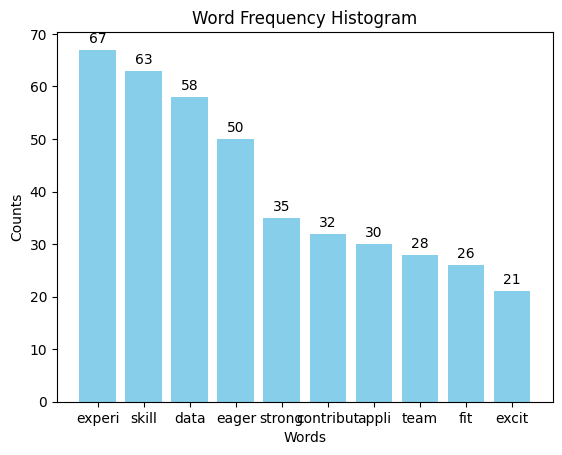

In [11]:
top_n = 10
top_10_words_overall = count_stem_freqs(claim_df, "Claim", top_n)

words, counts = zip(*top_10_words_overall.items())

# Plot the histogram
bars = plt.bar(words, counts, color='skyblue')
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Word Frequency Histogram')
plt.bar_label(bars, fmt='%d', padding=3)
plt.show()

Top 10 word stems for each level of detail:

/var/folders/3h/hhvlktwj1rzfznpk5wz5w45w0000gn/T/ipykernel_86066/775763399.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Stemmed_Claims"] = df[f"{text_col}"].apply(lambda x: stem_and_tokenize(x))


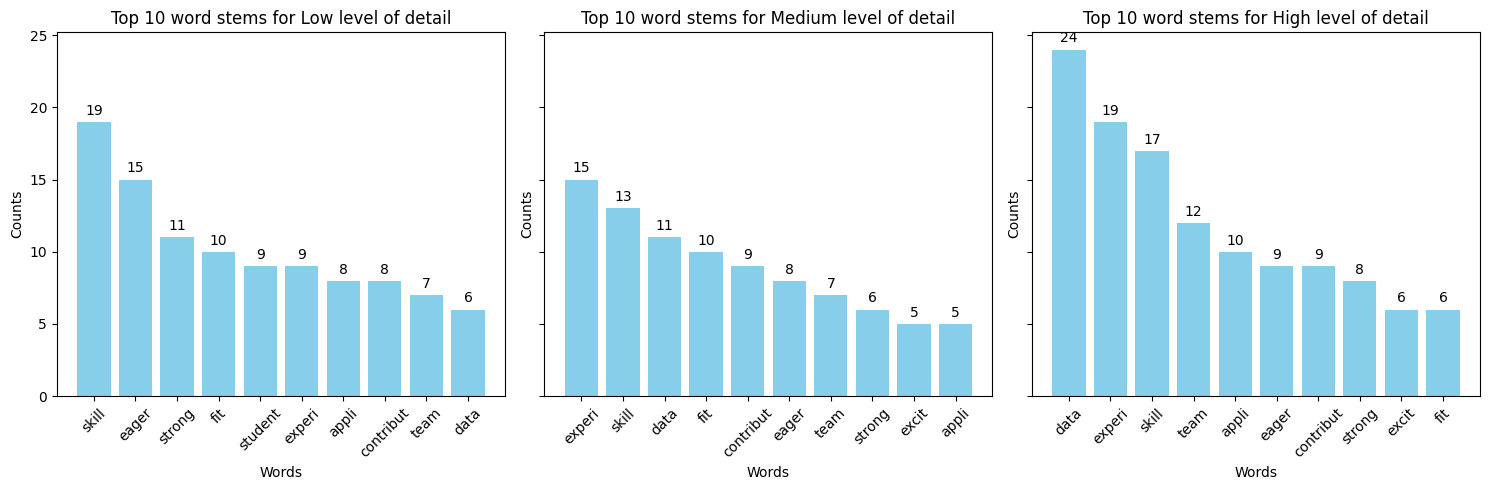

In [12]:
levels = ["Low", "Medium", "High"]
top_n = 10

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for i, level in enumerate(levels):
    level_df = claim_df[claim_df["Detail level"] == f"{level}"]
    top_10_words = count_stem_freqs(level_df, "Claim", top_n)
    
    words, counts = zip(*top_10_words.items())
    
    bars = axes[i].bar(words, counts, color='skyblue')
    axes[i].bar(words, counts, color='skyblue')
    axes[i].set_title(f"Top {top_n} word stems for {level} level of detail")
    axes[i].set_xlabel("Words")
    axes[i].set_ylabel("Counts")
    axes[i].tick_params(axis='x', rotation=45)  
    axes[i].bar_label(bars, fmt='%d', padding=3)

plt.tight_layout()
plt.show()

Top 10 word stems for each claim type (soft/hard):

/var/folders/3h/hhvlktwj1rzfznpk5wz5w45w0000gn/T/ipykernel_86066/775763399.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Stemmed_Claims"] = df[f"{text_col}"].apply(lambda x: stem_and_tokenize(x))


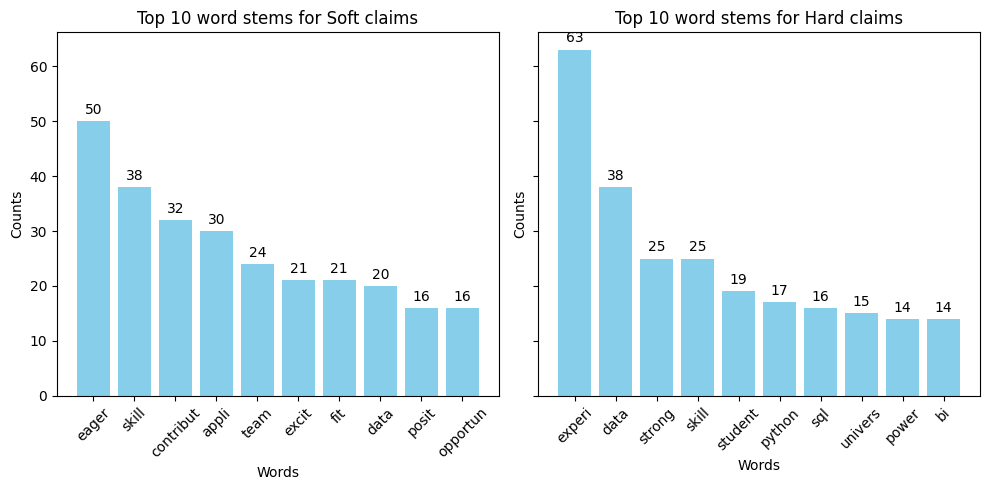

In [13]:
types = ["Soft", "Hard"]
top_n = 10

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for i, type in enumerate(types):
    type_df = claim_df[claim_df["Soft/hard"] == f"{type}"]
    top_10_words = count_stem_freqs(type_df, "Claim", top_n)
    
    words, counts = zip(*top_10_words.items())
    
    bars = axes[i].bar(words, counts, color='skyblue')
    axes[i].bar(words, counts, color='skyblue')
    axes[i].set_title(f"Top {top_n} word stems for {type} claims")
    axes[i].set_xlabel("Words")
    axes[i].set_ylabel("Counts")
    axes[i].tick_params(axis='x', rotation=45)  
    axes[i].bar_label(bars, fmt='%d', padding=3)

plt.tight_layout()
plt.show()